In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve, confusion_matrix

# Import data and create datasets

As labels dos dados estão definidas tais que:
- Background: 0
- Sinal: 1

In [2]:
# Gather data
bkgd = pd.read_hdf("Data/Background.h5", key='bkgd')
fcnc = pd.read_hdf("Data/FCNC.h5", key="fcnc")
X_train = pd.concat([bkgd, fcnc])
X_train.describe()

,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT,gen_weights,Label
count,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,...,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06,4.440800e+06
mean,4.642362e-06,4.102770e+01,1.146982e-03,3.100396e-06,1.036529e+01,-4.581339e-06,8.324586e-01,3.533756e-04,8.693247e+00,3.873254e+01,...,3.026105e-04,5.423478e+01,-1.956640e-04,-5.599270e-05,1.706459e+01,-1.866145e-05,1.196289e+00,3.714505e+02,1.064602e-04,4.407427e-02
std,8.472479e-01,5.473847e+01,1.371933e+00,5.798893e-01,2.252014e+01,9.181378e-01,8.186355e-01,4.162720e-01,2.652501e+01,1.099466e+02,...,9.976884e-01,5.717222e+01,1.571230e+00,7.815677e-01,2.605593e+01,1.198585e+00,8.223965e-01,2.021479e+02,5.091671e-04,2.052602e-01
min,-2.499997e+00,0.000000e+00,-3.141592e+00,-2.499985e+00,0.000000e+00,-3.141592e+00,0.000000e+00,-4.000467e+00,-6.103516e-05,0.000000e+00,...,-2.399990e+00,0.000000e+00,-3.141592e+00,-2.399981e+00,0.000000e+00,-3.141588e+00,0.000000e+00,4.447565e+01,3.264224e-09,0.000000e+00
25%,-1.986022e-01,0.000000e+00,-3.912720e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-5.680689e-01,1.020456e+01,-1.047653e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.342856e+02,5.842474e-07,0.000000e+00
50%,0.000000e+00,2.898474e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.799751e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.308271e+02,2.374618e-05,0.000000e+00
75%,2.005566e-01,6.450357e+01,3.971428e-01,0.000000e+00,1.263088e+01,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.684932e-01,7.523514e+01,1.046757e+00,0.000000e+00,3.088431e+01,0.000000e+00,2.000000e+00,4.581491e+02,2.458480e-05,0.000000e+00
max,2.499979e+00,2.124003e+03,3.141593e+00,2.499981e+00,9.984486e+02,3.141575e+00,5.000000e+00,3.873402e+00,7.324354e+02,2.939618e+03,...,2.399990e+00,2.646508e+03,3.141587e+00,2.399961e+00,1.217265e+03,3.141591e+00,5.000000e+00,4.926052e+03,3.651510e-03,1.000000e+00


In [3]:
fcnc.describe()

,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT,gen_weights,Label
count,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,...,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,195725.000000,1.957250e+05,195725.0
mean,-0.002376,93.874797,0.002506,-0.001356,24.843815,-0.000378,1.003965,-0.000878,39.842755,214.031343,...,-0.002890,122.098796,0.008965,-0.002141,36.443064,0.000233,1.373611,608.585528,3.264224e-09,1.0
std,0.956811,135.176460,1.411901,0.677618,50.790100,1.049370,0.959648,0.882671,48.378385,246.652396,...,1.084205,147.214662,1.571437,0.853159,58.101179,1.274687,1.002467,371.896309,6.990108e-21,0.0
min,-2.499965,0.000000,-3.141324,-2.499727,0.000000,-3.141587,0.000000,-3.494491,-0.000061,0.000000,...,-2.399990,0.000000,-3.141585,-2.399888,0.000000,-3.141572,0.000000,51.668472,3.264224e-09,1.0
25%,-0.343061,0.000000,-0.539507,0.000000,0.000000,0.000000,0.000000,-0.127633,0.000000,0.000000,...,-0.684100,0.000000,-1.031103,0.000000,0.000000,0.000000,0.000000,354.401245,3.264224e-09,1.0
50%,0.000000,43.226986,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.294422,216.051682,...,0.000000,79.353065,0.000000,0.000000,0.000000,0.000000,1.000000,512.929443,3.264224e-09,1.0
75%,0.332078,138.506805,0.549541,0.000000,32.493484,0.000000,2.000000,0.119289,91.306366,354.365540,...,0.672683,175.863571,1.061248,0.000000,53.818260,0.000000,2.000000,753.832581,3.264224e-09,1.0
max,2.499960,2124.003174,3.141387,2.499523,998.448608,3.141527,5.000000,3.708754,732.435364,2939.618408,...,2.399966,2646.508301,3.141582,2.399788,1217.265381,3.141448,5.000000,4926.052246,3.264224e-09,1.0


In [4]:
bkgd.describe()

,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT,gen_weights,Label
count,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,...,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4.245075e+06,4245075.0
mean,1.144244e-04,3.859111e+01,1.084335e-03,6.578391e-05,9.697738e+00,1.264110e-05,8.245510e-01,4.101399e-04,7.257056e+00,3.065015e+01,...,4.498187e-04,5.110581e+01,-6.180218e-04,4.014672e-05,1.617111e+01,-3.028545e-05,1.188113e+00,3.605171e+02,1.113686e-04,0.0
std,8.418525e-01,4.644635e+01,1.370063e+00,5.749829e-01,2.003727e+01,9.116318e-01,8.106689e-01,3.812480e-01,2.411029e+01,9.142469e+01,...,9.935177e-01,4.688299e+01,1.571220e+00,7.781081e-01,2.316157e+01,1.194959e+00,8.122001e-01,1.834634e+02,5.202477e-04,0.0
min,-2.499997e+00,0.000000e+00,-3.141592e+00,-2.499985e+00,0.000000e+00,-3.141592e+00,0.000000e+00,-4.000467e+00,-5.285799e-05,0.000000e+00,...,-2.399985e+00,0.000000e+00,-3.141592e+00,-2.399981e+00,0.000000e+00,-3.141588e+00,0.000000e+00,4.447565e+01,1.304437e-07,0.0
25%,-1.928962e-01,0.000000e+00,-3.839418e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-5.635411e-01,1.028139e+01,-1.048443e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.310312e+02,5.842474e-07,0.0
50%,0.000000e+00,2.859756e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.753570e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.254956e+02,2.374618e-05,0.0
75%,1.953454e-01,6.321899e+01,3.898618e-01,0.000000e+00,1.121624e+01,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.642138e-01,7.347187e+01,1.046109e+00,0.000000e+00,3.038062e+01,0.000000e+00,2.000000e+00,4.480336e+02,2.458480e-05,0.0
max,2.499979e+00,1.451913e+03,3.141593e+00,2.499981e+00,5.076544e+02,3.141575e+00,5.000000e+00,3.873402e+00,5.243948e+02,1.723009e+03,...,2.399990e+00,1.249431e+03,3.141587e+00,2.399961e+00,6.135786e+02,3.141591e+00,4.000000e+00,3.903838e+03,3.651510e-03,0.0


In [5]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_train.drop(columns="Label"), X_train["Label"], 
                                                    test_size=1/3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=40)

In [6]:
print(f"Train_size: {len(y_train)} | Val size: {len(y_val)} | Test_size: {len(y_test)}")

Train_size: 1480266 | Val size: 1480267 | Test_size: 1480267


In [7]:
# Get sample weights
train_weights = X_train["gen_weights"]
val_weights = X_val["gen_weights"]
test_weights = X_test["gen_weights"]

# Get samples
train_samples = X_train["Sample"]
val_samples = X_val["Sample"]
test_samples = X_test["Sample"]

# Get features
X_train = X_train.drop(["gen_weights", "Sample"], axis=1)
X_val = X_val.drop(["gen_weights", "Sample"], axis=1)
X_test = X_test.drop(["gen_weights", "Sample"], axis=1)

# Get class weights
# Class 0 (background) is the reference class, with weight 1
class_weights = {
    0: 1,
    1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])
}

In [8]:
print(f"X_train: {X_train.values.shape} | y_train: {y_train.values.shape} | train_weights: {train_weights.values.shape}")
print(f"X_val: {X_val.values.shape} | y_val: {y_val.values.shape} | val_weights: {val_weights.values.shape}")
print(f"X_test: {X_test.values.shape} | y_test: {y_test.values.shape} | test_weights: {test_weights.values.shape}")

X_train: (1480266, 69) | y_train: (1480266,) | train_weights: (1480266,)
X_val: (1480267, 69) | y_val: (1480267,) | val_weights: (1480267,)
X_test: (1480267, 69) | y_test: (1480267,) | test_weights: (1480267,)


# Build the model

In [9]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_samples):
        self.means = np.mean(data_samples, axis=0, keepdims=True)
        self.stds = np.std(data_samples, axis=0, keepdims=True)
        
    def call(self, inputs):
        return (inputs - self.means) / (self.stds + keras.backend.epsilon())
    
std_layer = Standardization()
std_layer.adapt(X_train.values)

Tentar um modelo com menos complexidade e utilizar MC Dropout para tentar obter melhores resultados

In [10]:
inputs = keras.Input(shape=(69,))
standardize = std_layer(inputs)
fc1 = keras.layers.Dense(55, activation='relu')(inputs)
d1 = keras.layers.Dropout(0.1)(fc1, training=True)
fc2 = keras.layers.Dense(40, activation='relu')(d1)
d2 = keras.layers.Dropout(0.1)(fc2, training=True)
fc3 = keras.layers.Dense(25, activation='relu')(d2)
#d3 = keras.layers.Dropout(0.1)(fc3, training=True)
#fc4 = keras.layers.Dense(40, activation='relu')(d3)
outputs = keras.layers.Dense(1, activation='sigmoid')(fc3)
model = keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss="binary_crossentropy",
              metrics=["accuracy", keras.metrics.AUC()])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
dense (Dense)                (None, 55)                3850      
_________________________________________________________________
dropout (Dropout)            (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1025      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26    

In [12]:
# Model name
name = "HiddenDense:55,40,25|BatchS:512|Dropout:0.1"

# Callbacks 

In [13]:
# Tensorboard
TB = keras.callbacks.TensorBoard("logs/" + name, write_images=True)

# Early Stopping
ES = keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, verbose=2, mode="min")

# Model Checkpoint
MC = keras.callbacks.ModelCheckpoint("models/" + name + ".h5", save_best_only=True, monitor="val_loss",
                                     mode="min")

# Treinar modelo

O modelo tem uma AUC consideravelmente baixa

In [14]:
start = time.time()
history = model.fit(X_train.values, y_train.values, batch_size=512,
                    epochs=80, shuffle=True, validation_data=(X_val.values, y_val.values),
                    sample_weight=train_weights.values, class_weight=class_weights, 
                    callbacks=[TB, ES, MC])
end = time.time()
print(f"The training took {(end - start)/3600} hours")

Epoch 1/80
2892/2892 [==============================] - 28s 10ms/step - loss: 4.6892e-07 - accuracy: 0.9557 - auc: 0.5012 - val_loss: 1.3678 - val_accuracy: 0.9558 - val_auc: 0.5036
Epoch 2/80
2892/2892 [==============================] - 27s 9ms/step - loss: 8.0221e-08 - accuracy: 0.9561 - auc: 0.5057 - val_loss: 1.0838 - val_accuracy: 0.9558 - val_auc: 0.5009
Epoch 3/80
2892/2892 [==============================] - 27s 9ms/step - loss: 7.2969e-08 - accuracy: 0.9562 - auc: 0.5092 - val_loss: 0.7377 - val_accuracy: 0.9558 - val_auc: 0.5144
Epoch 4/80
2892/2892 [==============================] - 27s 9ms/step - loss: 5.5541e-08 - accuracy: 0.9562 - auc: 0.5173 - val_loss: 0.6479 - val_accuracy: 0.9558 - val_auc: 0.5231
Epoch 5/80
2892/2892 [==============================] - 28s 10ms/step - loss: 5.1357e-08 - accuracy: 0.9562 - auc: 0.5289 - val_loss: 0.5972 - val_accuracy: 0.9558 - val_auc: 0.5321
Epoch 6/80
2892/2892 [==============================] - 27s 9ms/step - loss: 4.8938e-08 - acc

32 BS: 170s per epoch

128 BS: 150s per epoch

256 BS: 125s per epoch

1024 BS: 95s per epoch

# Tests and predictions

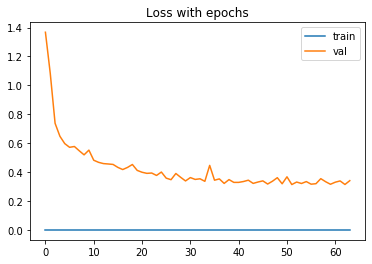

In [27]:
plt.title("Loss with epochs")
plt.plot(history.history["loss"], label='train')
plt.plot(history.history["val_loss"], label='val')
plt.legend()
plt.show()

In [28]:
y_preds = model.predict(X_val.values, batch_size=1024).reshape(-1)

In [17]:
accuracy_score(y_val.values, y_preds.round())

0.9560950828465405

Muito sinal classificado como bkgd !!! 10 x mais do que sinal corretamente classificado

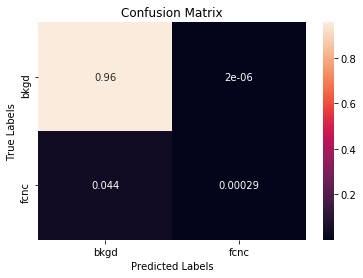

In [18]:
cm = confusion_matrix(y_val.values, y_preds.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "fcnc"])
ax.yaxis.set_ticklabels(["bkgd", "fcnc"])
plt.show()

# Monte Carlo Dropout

In [19]:
mcpreds = []
num_preds = 100

for _ in tqdm(range(num_preds), total=num_preds, desc="MCDropout"):
    mcpreds.append(model.predict(X_val.values, batch_size=1024).reshape(-1))

mcpreds = np.array(mcpreds)

MCDropout: 100%|██████████| 100/100 [05:55<00:00,  3.55s/it]


In [20]:
mc_means = np.array(mcpreds).mean(axis=0)
mc_stds = np.array(mcpreds).std(axis=0)

In [21]:
accuracy_score(y_val.values, mc_means.round())

0.9560255008049223

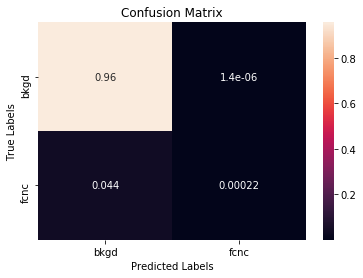

In [22]:
cm = confusion_matrix(y_val.values, mc_means.round(), normalize="all")

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.xaxis.set_ticklabels(["bkgd", "fcnc"])
ax.yaxis.set_ticklabels(["bkgd", "fcnc"])
plt.show()

## MCDropout by class

In [23]:
bkgd_means = mc_means[y_val == 0]
bkgd_stds = mc_means[y_val == 0]
fcnc_means = mc_means[y_val == 1]
fcnc_stds = mc_means[y_val == 1]

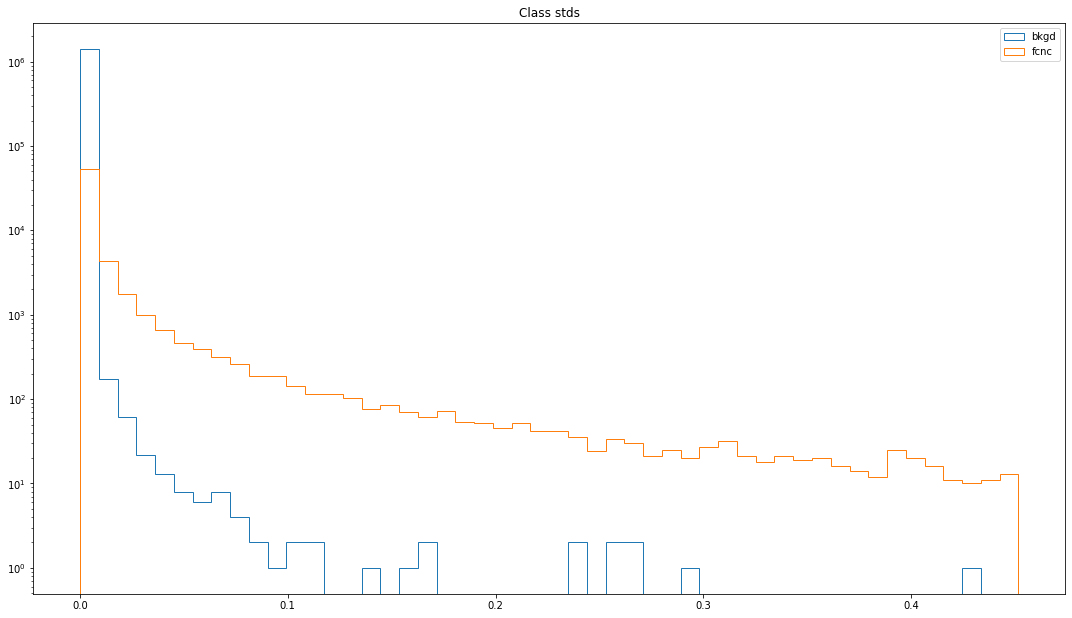

In [24]:
hist_range = (mc_stds.min(), mc_stds.max())

plt.title("Class stds")
plt.gcf().set_size_inches(18.5, 10.5)
plt.hist(bkgd_stds, bins=50, range=hist_range, label="bkgd", histtype="step")
plt.hist(fcnc_stds, bins=50, range=hist_range, label="fcnc", histtype="step")
plt.yscale("log")
plt.legend()
plt.show()

In [25]:
## MCDropout by sample
sample_list = glob("Data/dileptonic/*.csv")
sample_list += glob("Data/FCNC/*.h5")
sample_list = [s.split('/')[-1].split('.')[0] for s in sample_list]
sample_dict = {sample: (mc_means[val_samples==sample], mc_stds[val_samples==sample]) for sample in sample_list}

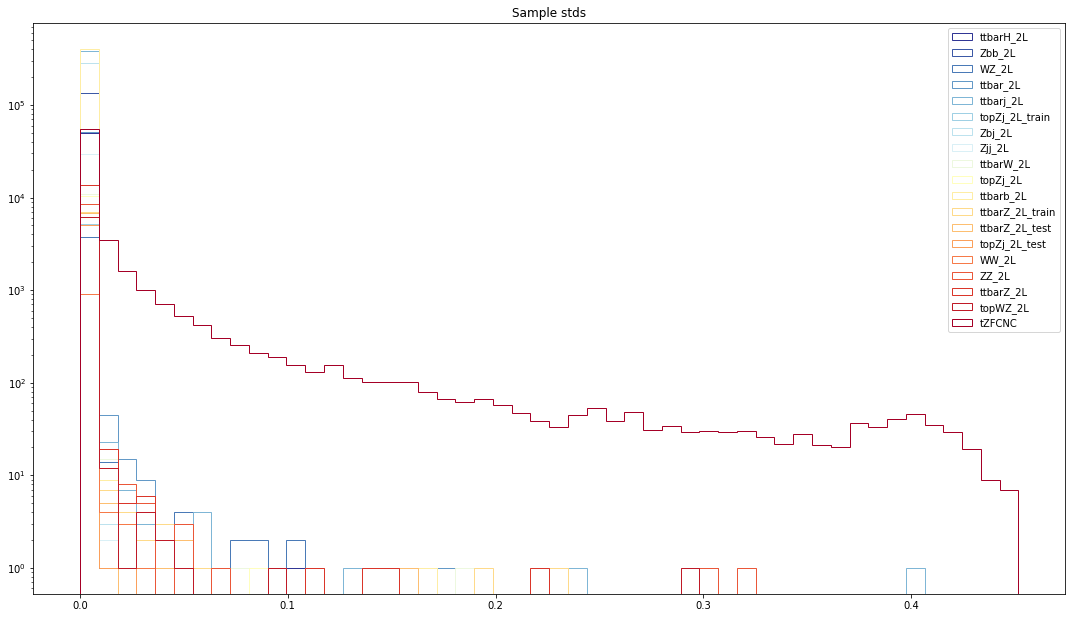

In [26]:
from cycler import cycler

colors = [plt.cm.get_cmap('RdYlBu_r')(i) for i in np.linspace(0, 1, len(sample_dict))]

plt.title("Sample stds")
plt.gcf().set_size_inches(18.5, 10.5)
plt.gca().set_prop_cycle(cycler('color', colors))

for sample in sample_dict:
    plt.hist(sample_dict[sample][1], bins=50, range=hist_range, histtype="step", label=sample)

plt.yscale("log")
plt.legend()
plt.show()

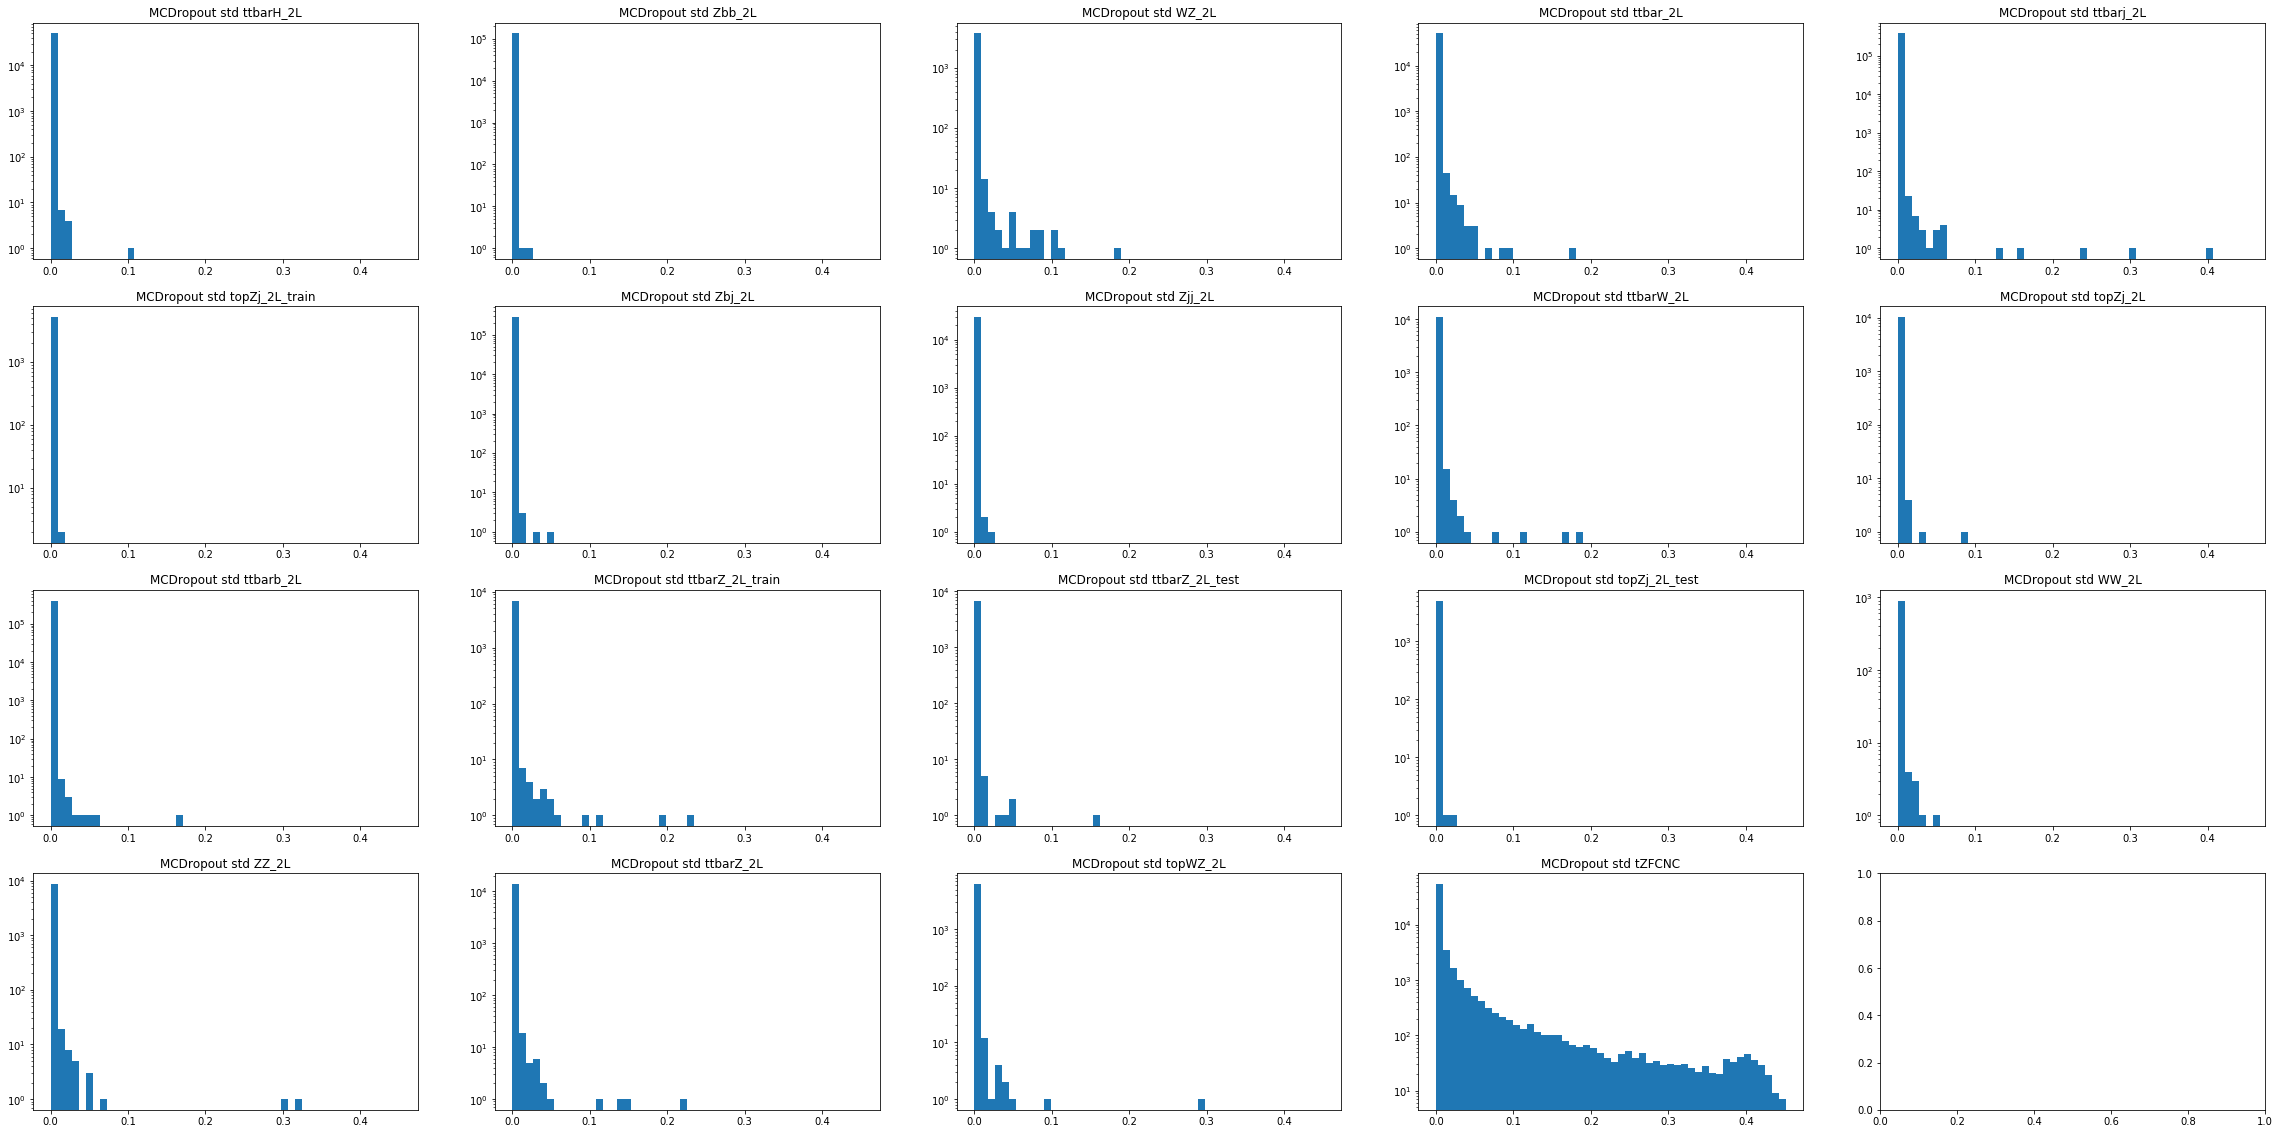

In [41]:
# Variáveis de ajuste dos plots
num_cols, bins = 5, 50

# Criar os plots
num_rows = int(np.ceil((len(sample_dict)) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 20))

# Iterar e plotar cada coluna de dados
for i, sample in enumerate(sample_dict):
    # Dar plot aos dados
    row, col = int(i/num_cols), i%num_cols
    axs[row, col].set_title("MCDropout std " + sample)
    axs[row, col].hist(sample_dict[sample][1], bins=50, range=hist_range)
    axs[row, col].set_yscale("log")
    
plt.show()